In [1]:
import pandas as pd
import time
import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from tdc.single_pred import Tox
from ersilia import ErsiliaModel

from scripts.data_loader import DataDownloader
from scripts.eda import ExploratoryDataAnalysis

from rdkit import Chem
from rdkit.Chem import Draw

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

%matplotlib inline

train = data.get_split()['train']

df["Y"].value_counts()

### **Getting to Know Our Data**  

In [2]:
downloader = DataDownloader()
data, df = downloader.fetch_herg_dataset()

2025-03-24 16:06:34,047 - INFO - Removing existing data directory: /home/gentroyal/outreachy-contributions/data
2025-03-24 16:06:34,066 - INFO - Downloading herg dataset...
Downloading...
100%|██████████████████| 50.2k/50.2k [00:00<00:00, 124kiB/s]
Loading...
Done!
2025-03-24 16:06:36,793 - INFO - Dataset saved to /home/gentroyal/outreachy-contributions/data/herg.csv (Shape: (655, 3))


help(Tox)

In [3]:
df.head()

Drug_ID                                               Drug    Y
0   DEMETHYLASTEMIZOLE  Oc1ccc(CCN2CCC(Nc3nc4ccccc4n3Cc3ccc(F)cc3)CC2)cc1  1.0
1            GBR-12909  Fc1ccc(C(OCC[NH+]2CC[NH+](CCCc3ccccc3)CC2)c2cc...  1.0
2             LY-97241             CCCCCCCN(CC)CCCCc1ccc([N+](=O)[O-])cc1  1.0
3  CLOFILIUM PHOSPHATE  CCCCCCC[N+](CC)(CC)CCCCc1ccc(Cl)cc1.CCCCCCC[N+...  1.0
4         FLUSPIRILENE  O=C1NCN(c2ccccc2)C12CC[NH+](CCCC(c1ccc(F)cc1)c...  1.0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655 entries, 0 to 654
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Drug_ID  633 non-null    object 
 1   Drug     655 non-null    object 
 2   Y        655 non-null    float64
dtypes: float64(1), object(2)
memory usage: 15.5+ KB


#### Some Useful Methods  

Some methods gotten from running `help(data)`, the`data` documentation that may be useful later:  
- **`get_label_meaning()`** – get the biomedical meaning of label.
- **`print_stats()`** to print the statistics of the dataset
- **`label_distribution()`** - visualize distribution of labels

This will be updated as needed

In [5]:
data.print_stats() #Exploring print_stats()

--- Dataset Statistics ---
648 unique drugs.
--------------------------


#### **Brief EDA** 

In [34]:
counts = dict(df.Y.value_counts()).items()

for key, value in counts:
    classification = "blockers" if key == 1.0 else "non-blockers"
    print(f"{value} drugs are classified as {classification}")


451 drugs are classified as blockers
204 drugs are classified as non-blockers


In [33]:
dict(df.Y.value_counts()).items()

dict_items([(1.0, 451), (0.0, 204)])

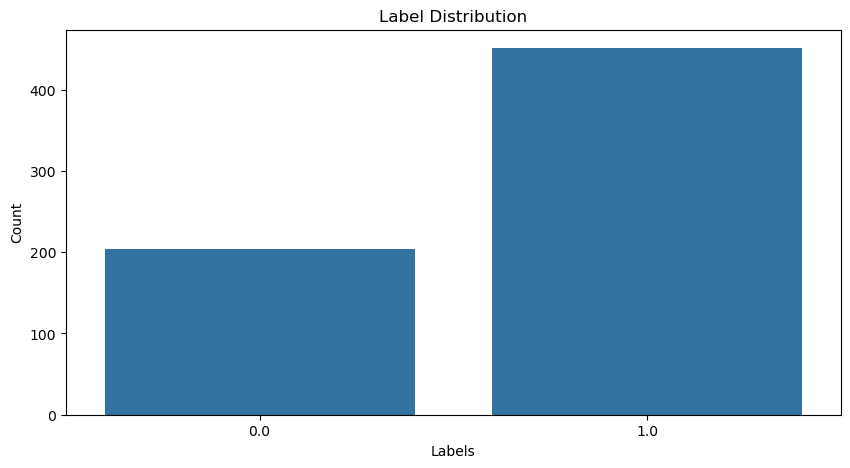

In [7]:
plt.figure(figsize=(10, 5))
sns.barplot(x = df.Y.value_counts().index, y = df.Y.value_counts().values)
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Label Distribution")
plt.show();

**Comment:** There are 451 blockers (classed as 1) and and 204 nonblockers (classed as 0). Since there is a huge difference in the number of samples in both classes, it means that there is an imbalance and we need to address this before we can train our machine learning model.

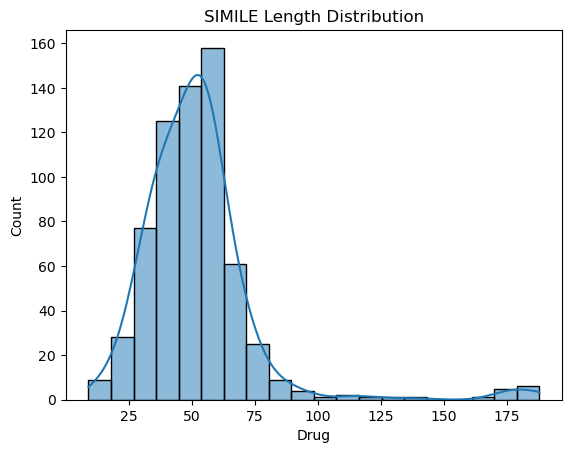

In [8]:
simile_length = df['Drug'].str.len()
sns.histplot(simile_length, bins=20, kde=True)
plt.title("SIMILE Length Distribution")
plt.show()

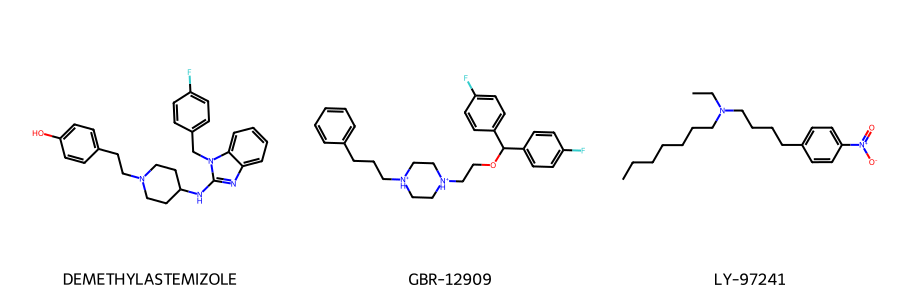

In [9]:
smiles_list = df["Drug"].iloc[:3].tolist()  # First 3 SMILES
drug_names = df["Drug_ID"].iloc[:3].tolist()  # Their  Names

mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
Draw.MolsToGridImage(mols, molsPerRow = 3, subImgSize=(300, 300), legends=drug_names)

**Comment:** 

### **Featurizer**  

help(ErsiliaModel)

In [10]:
def featurize(model_id, output_file):
    try:
        t1 = time.time()
        # Load Ersilia model
        
        model = ErsiliaModel(model = model_id)
        model.serve()
        
        # Run the model on input file
        result = model.run(
            input="../data/herg.csv",
            output = f"../data/{output_file}.csv"
        )

        # Load and return the featurized dataset
        df = pd.read_csv(f"../data/{output_file}.csv")
        timetaken = time.time() - t1
        
        return df, timetaken

    except Exception as e:
        print(f"Error during featurization: {e}")
        return None

In [11]:
def generate_output_filename(model_id, suffix="featurized"):
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    return f"{model_id}_{suffix}_{timestamp}"

'''
# Featurizers to Try
#1. eos24ci - DrugTax: Drug taxonomy. 
#2. eos1pu1 - Cardiotoxicity Classifier. 
#3. eos9p4a- Drug-likeness scoring based on unsupervised learning
'''

model_ids = ["eos24ci", "eos1pu1"] 
output_files = {model_id: generate_output_filename(model_id) for model_id in model_ids}

In [12]:
herg_drug_tax, time_drug_tax = featurize(model_id=model_ids[0], output_file=output_files[model_ids[0]])
herg_cardiotoxicity_classifier, time_cardiotoxicity_classifier = featurize(model_id=model_ids[1], output_file=output_files[model_ids[1]])

In [18]:
print(f'Time taken to featurize using {model_ids[0]} is: {time_drug_tax/60:.2f} minutes')
print(f'Time taken to featurize using {model_ids[1]} is: {time_cardiotoxicity_classifier/60:.2f} minutes')

Time taken to featurize using eos24ci is: 2.15 minutes
Time taken to featurize using eos1pu1 is: 51.74 minutes
